In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from sklearn.preprocessing import MaxAbsScaler
import xarray as xr

from utils import delayed_adstock
from plots import plot_posterior
from plots import plot_prior_predictive_samples


In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.2.0


In [3]:
raw = pd.read_csv('MMM_test_data.csv')
df=raw.copy()


In [4]:
spend_channels= ['spend_channel_1','spend_channel_2','spend_channel_3','spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
df['start_of_week'] = pd.to_datetime(df['start_of_week'],format="%d-%m-%y",dayfirst=True)
date_data= df['start_of_week']
channel_data = df[spend_channels]
target_data=df['revenue']
n_obs,n_channels= np.shape(channel_data)

In [5]:
#creating trend and seasonality
df['day'] = df.start_of_week.dt.dayofyear
n_order = 7
periods = df["day"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

trend = (df.index - df.index.min()) / (df.index.max() - df.index.min())
df['trend'] = trend
seasonality =  fourier_features



In [6]:
target_scaler = MaxAbsScaler()
target_scaler.fit(target_data.values.reshape(-1,1))
target_scaled = pd.Series(target_scaler.transform(target_data.values.reshape(-1,1)).flatten())

channel_scaler = MaxAbsScaler()
channel_scaler.fit(channel_data)
channel_scaled = pd.DataFrame(channel_scaler.transform(channel_data),columns=channel_data.columns)


<Axes: >

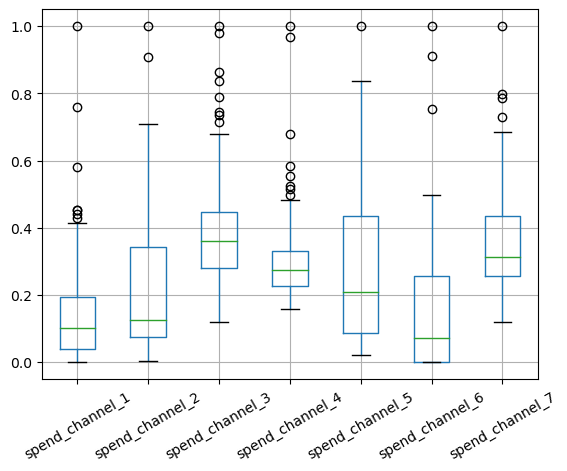

In [7]:
# outliers exist but the transformation is completed.
channel_scaled.boxplot( rot=30)

In [8]:
coords={"date": date_data,
        "channel": channel_scaled,
        "seasonality":seasonality,
        "trend":df['trend']}

In [9]:
max_lag=13

with pm.Model(coords=coords) as model:
    #data containers
    channel_data_ = pm.MutableData(
        name="channel_data",
        value=channel_scaled,
        dims=("date", "channel"),
    )
    seasonality_ = pm.MutableData(
        name="seasonality_data", value=seasonality, dims=("date", "seasonality")
    )
    trend_ = pm.MutableData(
        name="t", value=df['trend'], dims=("date")
    )
    
    target_ = pm.MutableData(name="target", value=target_scaled, dims="date")

    #priors
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=1)
    beta_channel = pm.HalfNormal(
        name="beta_channel", sigma=1, dims="channel"
    )
    alpha = pm.Beta(name="alpha", alpha=3, beta=3, dims="channel")
    theta = pm.Uniform('delay',lower=0,upper=max_lag-1,dims='channel')
    sigma = pm.HalfNormal(name="sigma", sigma=1)
    fourier_control = pm.Laplace(
        name="gamma_control", mu=0, b=1, dims="seasonality"
    )
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=15, beta=1)
    
    #model parametrization
    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=delayed_adstock(
            x=channel_data_,
            alpha=alpha,
            theta=theta,
            l_max = max_lag-1
        ),
        dims=("date", "channel"),
    )

    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock*beta_channel,
        dims=("date", "channel"),
    )
    
    mu_var =  channel_contributions.sum(axis=-1)
    
    trend = pm.Deterministic("trend", intercept + b_trend * trend_, dims="date")
    
    control_contributions = pm.Deterministic(
        name="control_contributions",
        var=seasonality_ * fourier_control,
        dims=("date", "seasonality"),
    )
    
    mu_var += control_contributions.sum(axis=-1)
    mu_var += trend
    mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

    pm.StudentT(
        name="likelihood",
        nu=nu,
        mu=mu,
        sigma=sigma,
        observed=target_,
        dims="date",
    )
    model_prior_predictive = pm.sample_prior_predictive()

Sampling: [alpha, b_trend, beta_channel, delay, gamma_control, intercept, likelihood, nu, sigma]


In [10]:
model

            intercept ~ N(0, 1)
              b_trend ~ N(0, 1)
         beta_channel ~ N**+(0, 1)
                alpha ~ Beta(3, 3)
                delay ~ U(0, 12)
                sigma ~ N**+(0, 1)
        gamma_control ~ Laplace(0, 1)
                   nu ~ Gamma(15, f())
      channel_adstock ~ Deterministic(f(alpha, delay))
channel_contributions ~ Deterministic(f(beta_channel, alpha, delay))
                trend ~ Deterministic(f(intercept, b_trend))
control_contributions ~ Deterministic(f(gamma_control))
                   mu ~ Deterministic(f(intercept, b_trend, gamma_control, beta_channel, alpha, delay))
           likelihood ~ StudentT(nu, mu, sigma)

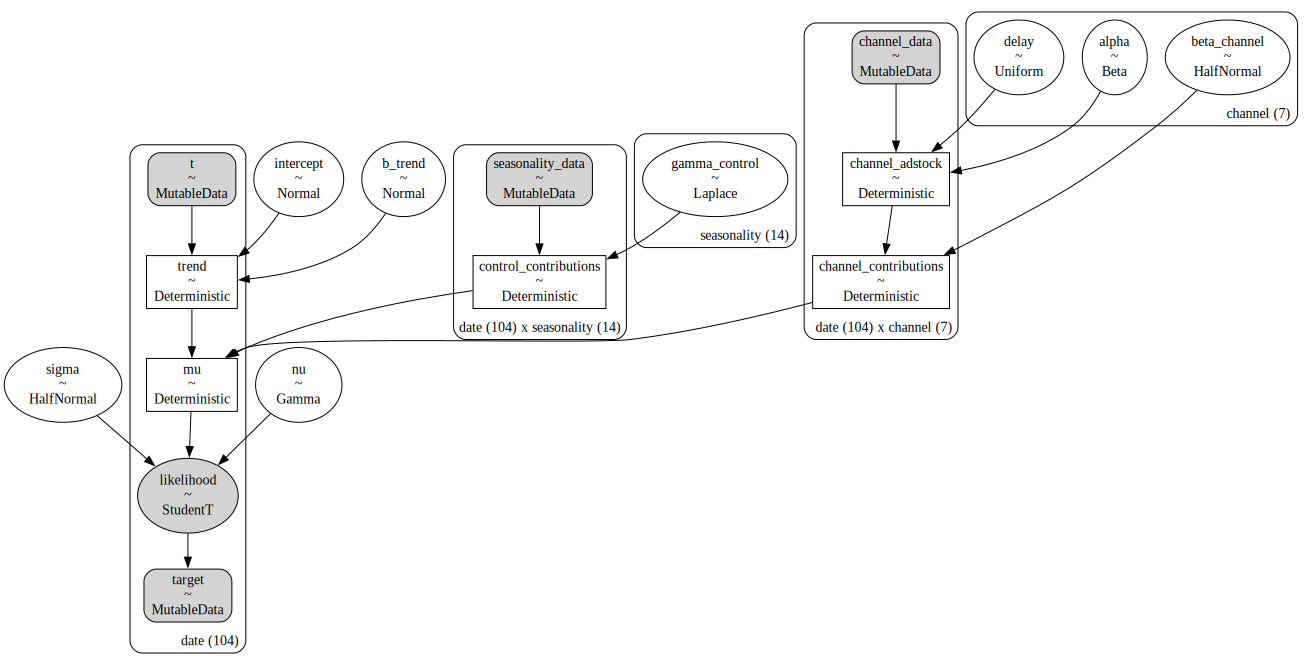

In [11]:
pm.model_to_graphviz(model=model)

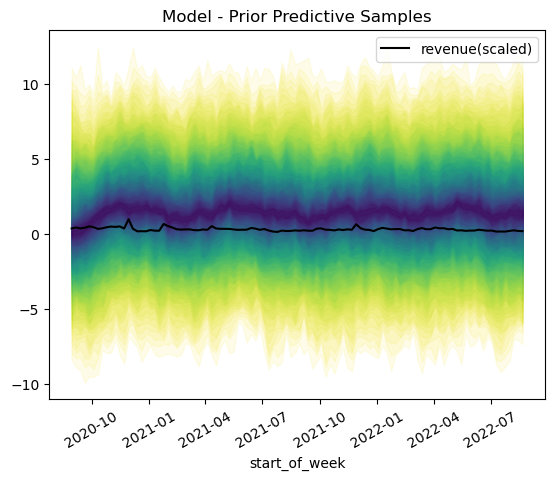

In [12]:
# useful way to color the distribution
plot_settings={
'palette' :"viridis_r",
'cmap' :plt.get_cmap("viridis_r"),
'percs' :np.linspace(51, 99, 100),
'colors' :(np.linspace(51, 99, 100) - np.min(np.linspace(51, 99, 100))) / (np.max(np.linspace(51, 99, 100)) - np.min(np.linspace(51, 99, 100)))}
plot_prior_predictive_samples(model_prior_predictive,target_scaled,date_data,plot_settings)


In [13]:
with model:
    model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive = pm.sample_posterior_predictive(
        trace=model_trace
    )

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)
/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:05.649317
Sampling...


Compiling.. :   0%|                                                                                                                                     | 0/9000 [00:00<?, ?it/s]

  0%|                                                                                                                                                   | 0/9000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                                                                     | 0/9000 [00:00<?, ?it/s]


  0%|                                                                                                                                                   | 0/9000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                                                                                                  | 0/9000 [00:05<?, ?it/s]

Running chain 0:   0%|                                                                                 

Running chain 1:  70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 6300/9000 [00:36<00:11, 225.19it/s]


Running chain 1:  75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 6750/9000 [00:38<00:10, 213.52it/s]

Running chain 1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 7200/9000 [00:41<00:08, 208.86it/s]


Running chain 3:  60%|██████████████████████████████████████████████████████████████████████▊                                               | 5400/9000 [00:41<00:24, 146.45it/s]

Running chain 1:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 7650/9000 [00:43<00:06, 210.63it/s]


Running chain 3:  65%|████████████████████████████████████████████████████████████████████████████▋   

Sampling time =  0:01:04.176775
Transforming variables...
Transformation time =  0:00:02.485296
Computing Log Likelihood...
Log Likelihood time =  0:00:02.543087


Sampling: [likelihood]


In [14]:
az.summary(
    data=model_trace,
    var_names=['alpha','delay','intercept','b_trend','beta_channel','sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
alpha[spend_channel_1]         0.475  0.192   0.130    0.822      0.001   
alpha[spend_channel_2]         0.598  0.186   0.251    0.918      0.001   
alpha[spend_channel_3]         0.445  0.173   0.133    0.771      0.001   
alpha[spend_channel_4]         0.513  0.190   0.164    0.857      0.001   
alpha[spend_channel_5]         0.498  0.186   0.152    0.829      0.001   
alpha[spend_channel_6]         0.554  0.174   0.224    0.852      0.001   
alpha[spend_channel_7]         0.501  0.182   0.160    0.830      0.001   
delay[spend_channel_1]         6.458  2.570   1.027   10.598      0.031   
delay[spend_channel_2]         3.661  2.293   0.001    8.380      0.029   
delay[spend_channel_3]         0.357  0.804   0.000    0.629      0.023   
delay[spend_channel_4]         4.827  3.250   0.001   10.248      0.029   
delay[spend_channel_5]         4.615  3.732   0.000   11.053      0.031   
delay[spend_channel_6]         1.347  0.735   0.112    2.238      0.008   
delay[spend_channel_7]         3.185  1.146   0.181    4.303      0.025   
intercept                      0.012  0.074  -0.126    0.155      0.001   
b_trend                       -0.185  0.080  -0.338   -0.035      0.001   
beta_channel[spend_channel_1]  0.116  0.086   0.000    0.269      0.001   
beta_channel[spend_channel_2]  0.225  0.105   0.029    0.418      0.001   
beta_channel[spend_channel_3]  0.374  0.120   0.156    0.609      0.002   
beta_channel[spend_channel_4]  0.087  0.073   0.000    0.219      0.001   
beta_channel[spend_channel_5]  0.041  0.045   0.000    0.124      0.000   
beta_channel[spend_channel_6]  0.304  0.095   0.125    0.486      0.002   
beta_channel[spend_channel_7]  0.319  0.116   0.090    0.534      0.001   
sigma                          0.057  0.007   0.044    0.071      0.000   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
alpha[spend_channel_1]           0.001   25501.0   21864.0    1.0  
alpha[spend_channel_2]           0.001   22850.0   21864.0    1.0  
alpha[spend_channel_3]           0.001   18951.0   13013.0    1.0  
alpha[spend_channel_4]           0.001   34079.0   22478.0    1.0  
alpha[spend_channel_5]           0.001   38632.0   21647.0    1.0  
alpha[spend_channel_6]           0.001   23432.0   21769.0    1.0  
alpha[spend_channel_7]           0.001   22679.0   16871.0    1.0  
delay[spend_channel_1]           0.022    9654.0   14774.0    1.0  
delay[spend_channel_2]           0.020    6849.0    9458.0    1.0  
delay[spend_channel_3]           0.016    4296.0    1437.0    1.0  
delay[spend_channel_4]           0.020   12810.0   16785.0    1.0  
delay[spend_channel_5]           0.022   17164.0   21223.0    1.0  
delay[spend_channel_6]           0.008   13452.0   12542.0    1.0  
delay[spend_channel_7]           0.017    3312.0    1446.0    1.0  
intercept                        0.001    3361.0    3313.0    1.0  
b_trend                          0.001    9212.0   12585.0    1.0  
beta_channel[spend_channel_1]    0.001    8547.0   12851.0    1.0  
beta_channel[spend_channel_2]    0.001    8010.0    9003.0    1.0  
beta_channel[spend_channel_3]    0.001    3291.0    2645.0    1.0  
beta_channel[spend_channel_4]    0.000   12764.0   14834.0    1.0  
beta_channel[spend_channel_5]    0.000   14320.0   16503.0    1.0  
beta_channel[spend_channel_6]    0.001    4302.0    3507.0    1.0  
beta_channel[spend_channel_7]    0.001    7257.0    4652.0    1.0  
sigma                            0.000   10974.0   19080.0    1.0

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


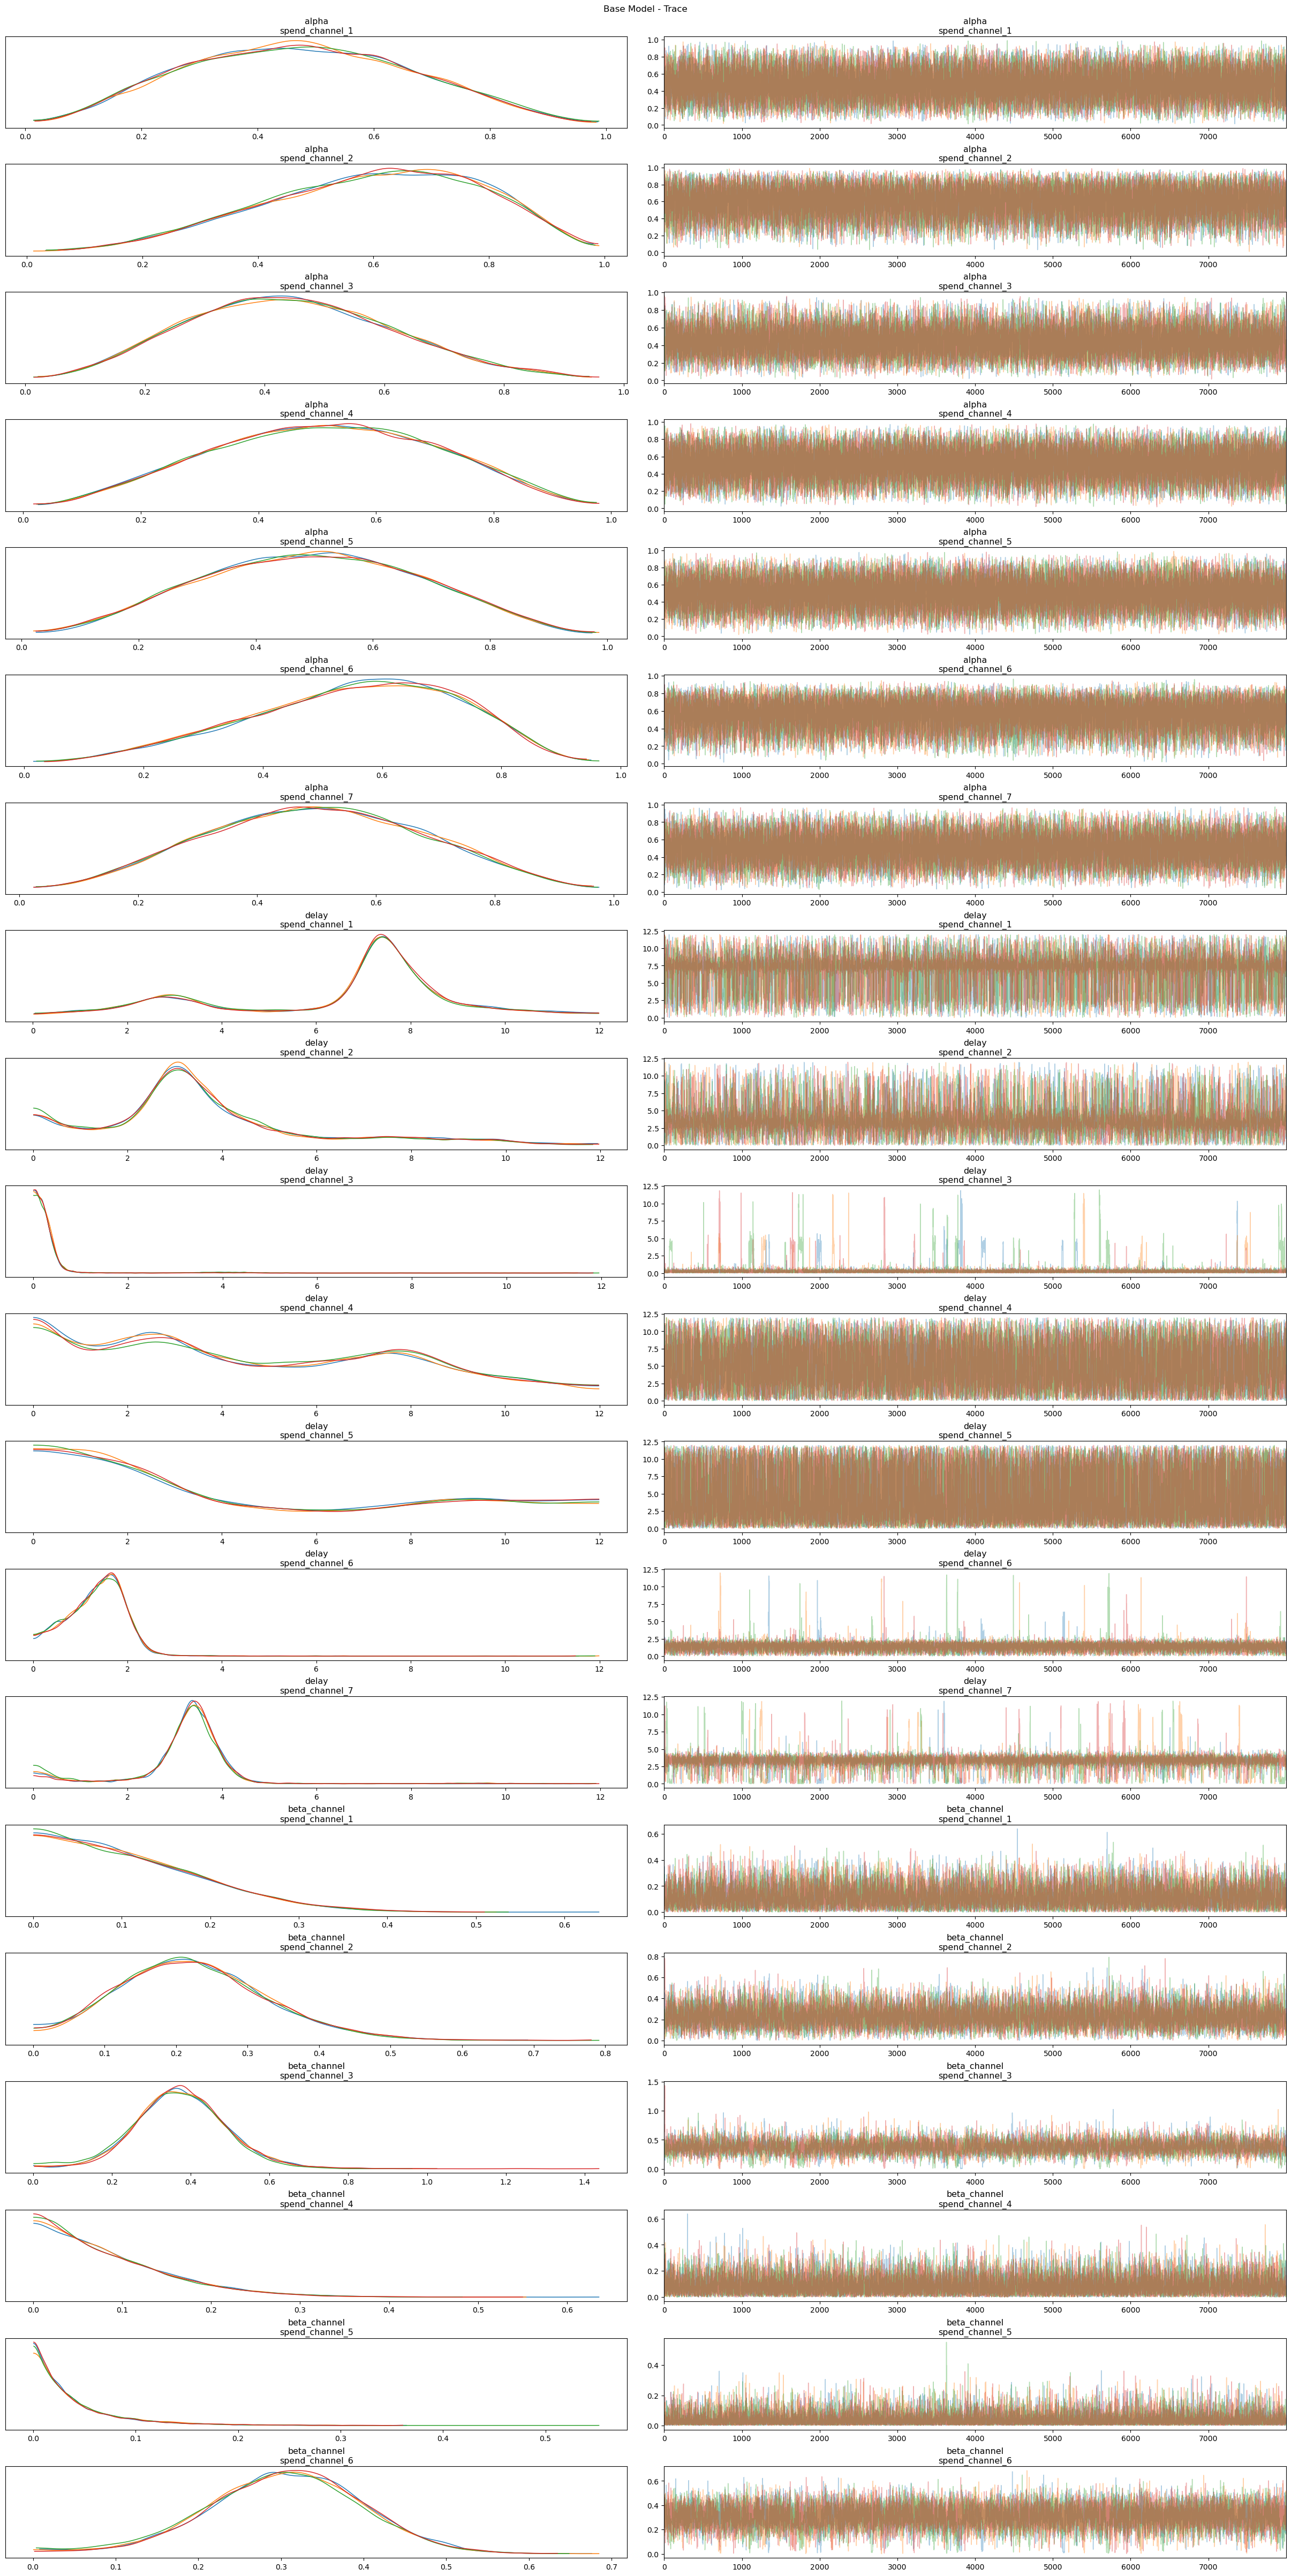

In [15]:
axes = az.plot_trace(
    data=model_trace,
#     var_names=['alpha','delay','intercept','b_trend','beta_channel','nu','gamma_control'],
    var_names=['alpha','delay','beta_channel','sigma'],
    compact=False,
    combined=False,
    backend_kwargs={
        "figsize": (24, 48),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace")
plt.show()
# here we see on the right side distribtuion on each chain seperatly . on left we see the 
# convergence on each chain.

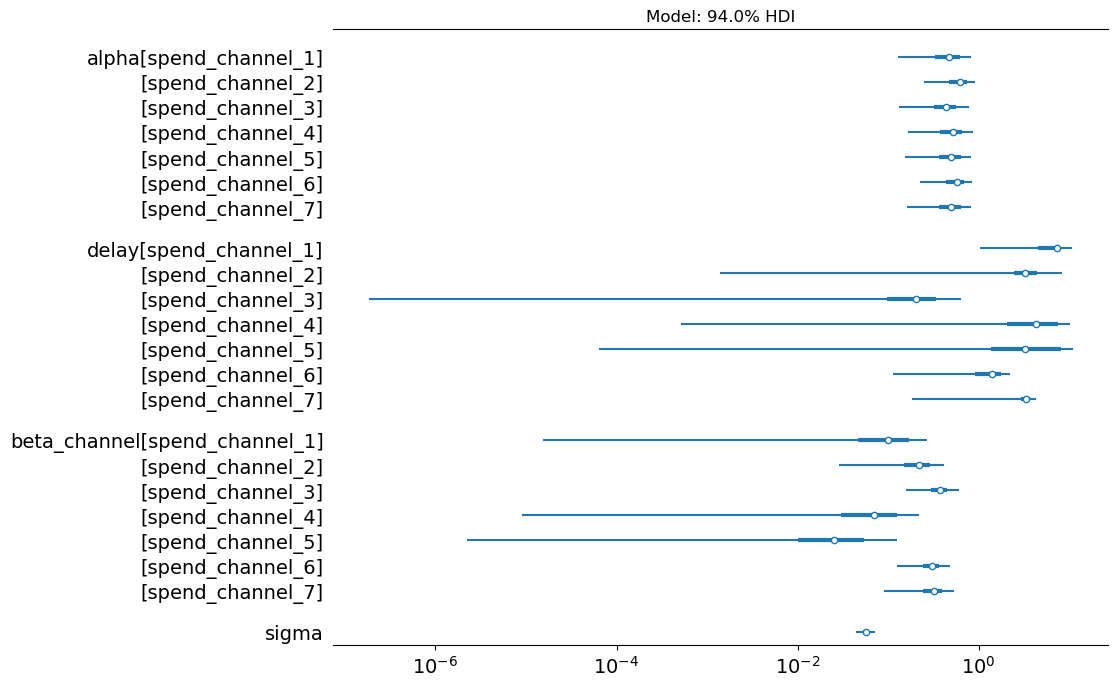

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
az.plot_forest(
    data=model_trace,
    var_names=['alpha','delay','beta_channel','sigma'],
    combined=True,
    ax=ax
)
ax.set(
    title="Model: 94.0% HDI",
    xscale="log"
)
plt.show()

In [17]:
## posterior prediction

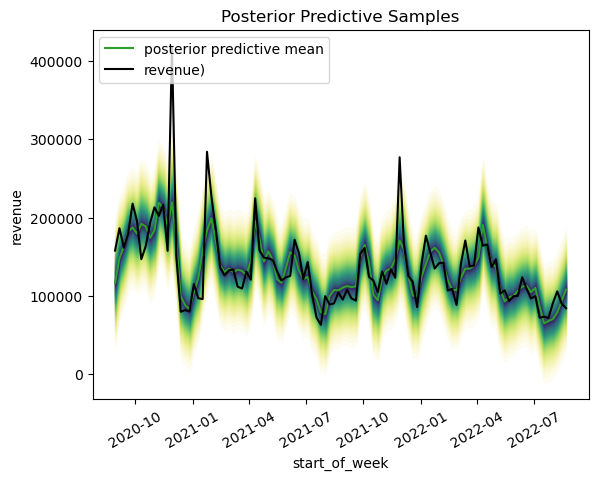

In [18]:
plot_posterior(model_posterior_predictive,date_data,target_data,target_scaler,plot_settings)


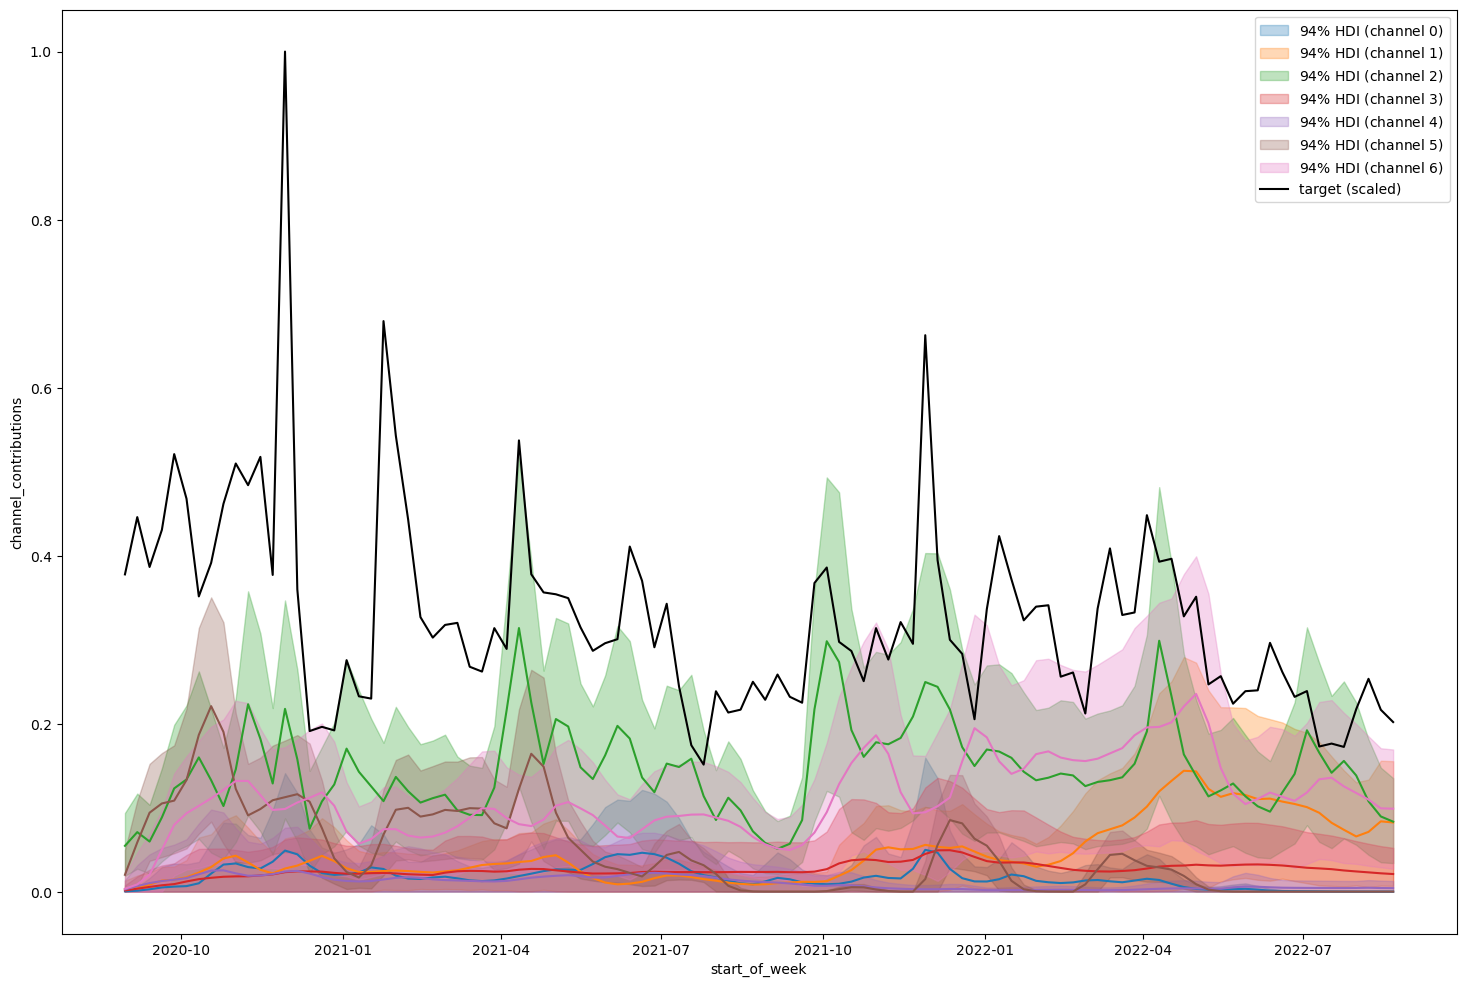

In [19]:
#The HDI can be used in the context of
#uncertainty characterisation of posterior distributions as Credible Interval (CI).
model_hdi = az.hdi(ary=model_trace)

fig, ax = plt.subplots(figsize=(18, 12))

for i in range(n_channels):
    ax.fill_between(
        x=date_data,
        y1=model_hdi['channel_contributions'][:, i,0],
        y2=model_hdi['channel_contributions'][:, i,1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI (channel {i})",
    )
    sns.lineplot(
        x=date_data,
        y=model_trace.posterior['channel_contributions'].stack(sample=("chain", "draw")).mean(axis=2)[:,i]
    )
sns.lineplot(x=date_data, y=target_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax)
plt.show()

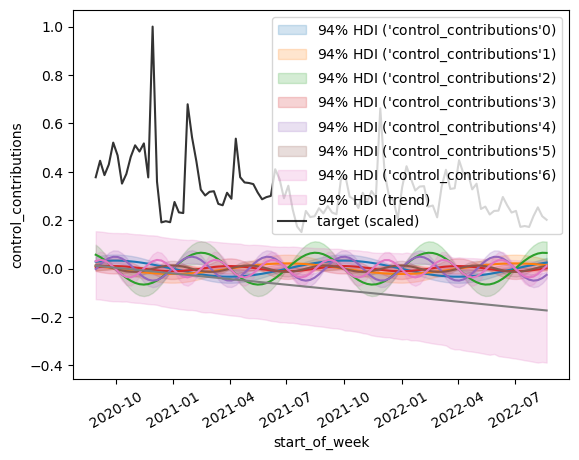

In [20]:
# compute HDI for all the control parameters
fig, ax = plt.subplots()

for i in range(n_channels):
    ax.fill_between(
        x=date_data,
        y1=model_hdi['control_contributions'][:, i,0],
        y2=model_hdi['control_contributions'][:, i,1],
        color=f"C{i}",
        alpha=0.2,
        label=f"$94\%$ HDI ('control_contributions'{i})",
    )
    sns.lineplot(
        x=date_data,
        y=model_trace.posterior['control_contributions'].stack(sample=("chain", "draw")).mean(axis=2)[:,i]
    )

ax.fill_between(
    x=date_data,
    y1=model_hdi['trend'][:,0],
    y2=model_hdi['trend'][:,1],
    color=f"C{i}",
    alpha=0.2,
    label=f"$94\%$ HDI ({'trend'})",
)
sns.lineplot(
    x=date_data,
    y=model_trace.posterior['trend'].stack(sample=("chain", "draw")).mean(axis=1)
)
sns.lineplot(x=date_data, y=target_scaled, color="black", alpha=0.8, label="target (scaled)", ax=ax)
plt.xticks(rotation=30)
plt.show()

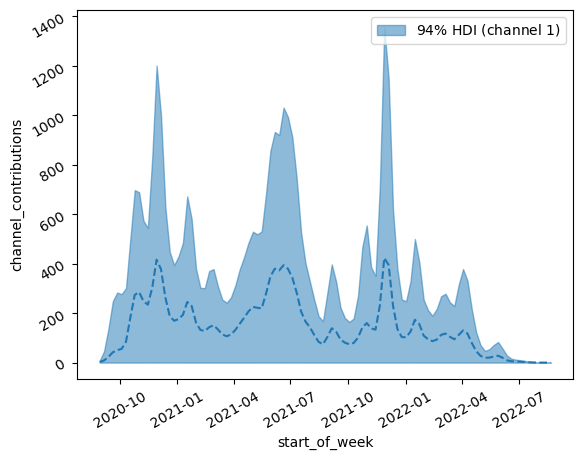

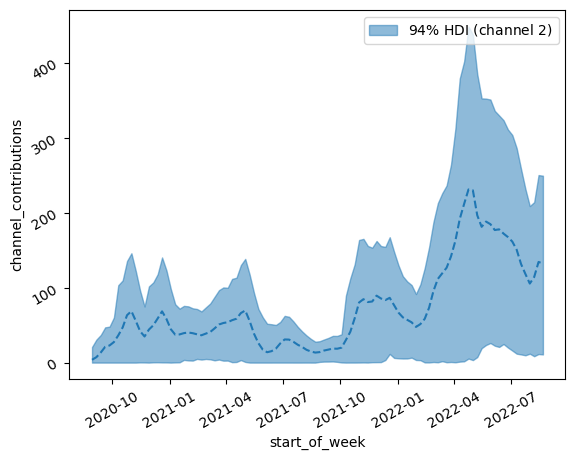

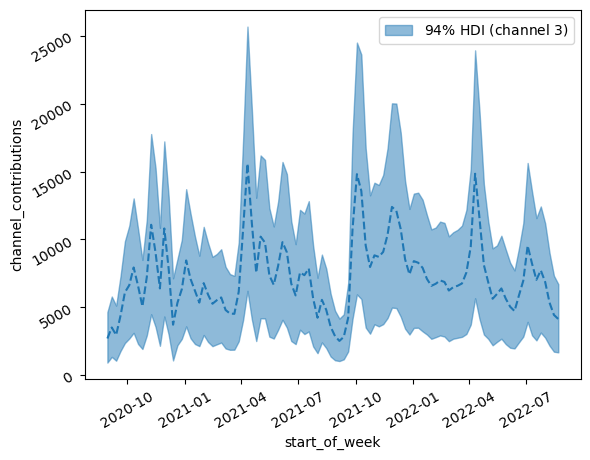

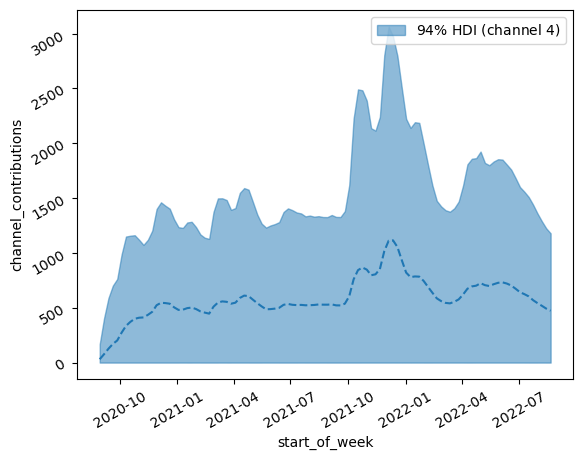

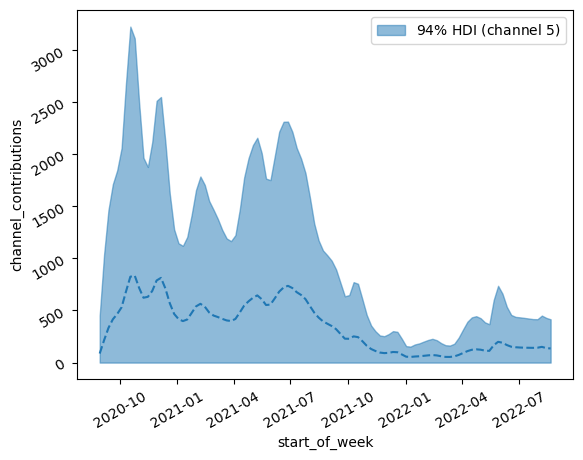

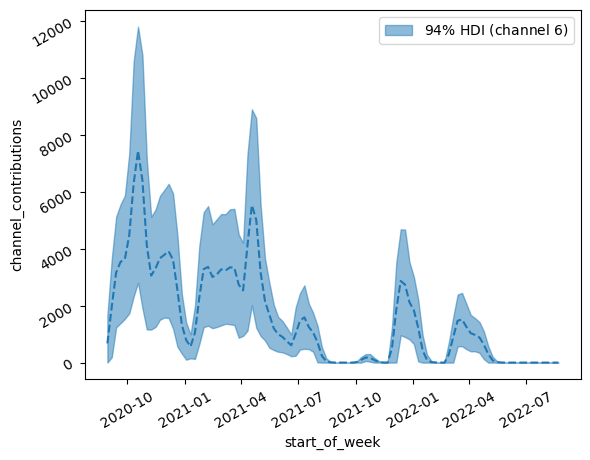

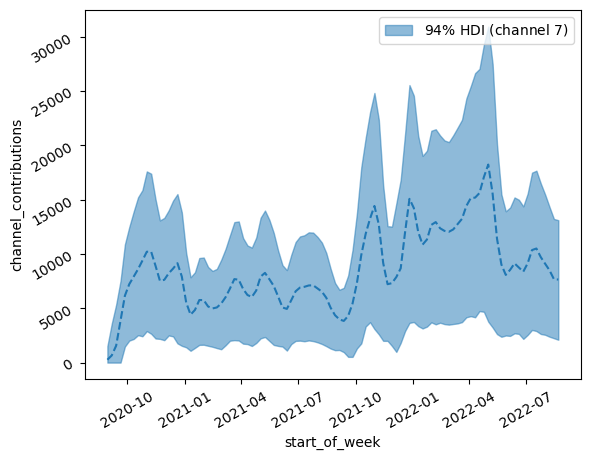

In [21]:
#channel contribtuion figures

channel_contributions_posterior_samples = xr.apply_ufunc(
    lambda x: channel_scaler.inverse_transform(X=x),
    model_trace.posterior["channel_contributions"],
    input_core_dims=[["date","channel"]],
    output_core_dims=[["date","channel"]],
    vectorize=True,
)


channel_effect_hdi = az.hdi(ary=channel_contributions_posterior_samples)["channel_contributions"]

for i in range(n_channels):

    fig, ax = plt.subplots()
    ax.fill_between(
        x=date_data,
        y1=channel_effect_hdi[:,i ,0],
        y2=channel_effect_hdi[:,i ,1],
        color="C0",
        alpha=0.5,
        label=f"$94\%$ HDI (channel {i+1})",
    )
    ax.tick_params(labelrotation=30)
    sns.lineplot(
        x=date_data,
        y=channel_contributions_posterior_samples.stack(sample=("chain", "draw")).mean(axis=2)[:,i],
        linestyle="--",
    )
ax.legend(loc="upper right")
plt.show()

In [22]:
# 2nd model with normal likelihood
max_lag=13

with pm.Model(coords=coords) as model_normal:
    #data containers
    channel_data_ = pm.MutableData(
        name="channel_data",
        value=channel_scaled,
        dims=("date", "channel"),
    )
    seasonality_ = pm.MutableData(
        name="seasonality_data", value=seasonality, dims=("date", "seasonality")
    )
    trend_ = pm.MutableData(
        name="t", value=df['trend'], dims=("date")
    )
    
    target_ = pm.MutableData(name="target", value=target_scaled, dims="date")

    #-priors
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=1)
    beta_channel = pm.HalfNormal(
        name="beta_channel", sigma=1, dims="channel"
    )
    alpha = pm.Beta(name="alpha", alpha=3, beta=3, dims="channel")
    theta = pm.Uniform('delay',lower=0,upper=max_lag,dims='channel')
    sigma = pm.HalfNormal(name="sigma", sigma=1)
    fourier_control = pm.Laplace(
        name="gamma_control", mu=0, b=1, dims="seasonality"
    )
    #model parametrization
    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=delayed_adstock(
            x=channel_data_,
            alpha=alpha,
            theta=theta,
            l_max = max_lag-1
        ),
        dims=("date", "channel"),
    )

    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock*beta_channel,
        dims=("date", "channel"),
    )
    
    mu_var =  channel_contributions.sum(axis=-1)
    
    trend = pm.Deterministic("trend", intercept + b_trend * trend_, dims="date")
    
    control_contributions = pm.Deterministic(
        name="control_contributions",
        var=seasonality_ * fourier_control,
        dims=("date", "seasonality"),
    )
    
    mu_var += control_contributions.sum(axis=-1)
    mu_var += trend
    mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

    pm.Normal(
                name="likelihood",
                mu=mu,
                sigma=sigma,
                observed=target_,
                dims="date",
            )
    model_prior_predictive_normal = pm.sample_prior_predictive()

Sampling: [alpha, b_trend, beta_channel, delay, gamma_control, intercept, likelihood, sigma]


In [23]:
model_normal

            intercept ~ N(0, 1)
              b_trend ~ N(0, 1)
         beta_channel ~ N**+(0, 1)
                alpha ~ Beta(3, 3)
                delay ~ U(0, 13)
                sigma ~ N**+(0, 1)
        gamma_control ~ Laplace(0, 1)
      channel_adstock ~ Deterministic(f(alpha, delay))
channel_contributions ~ Deterministic(f(beta_channel, alpha, delay))
                trend ~ Deterministic(f(intercept, b_trend))
control_contributions ~ Deterministic(f(gamma_control))
                   mu ~ Deterministic(f(intercept, b_trend, gamma_control, beta_channel, alpha, delay))
           likelihood ~ N(mu, sigma)

In [24]:
with model_normal:
    model_trace_normal = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive_normal = pm.sample_posterior_predictive(
        trace=model_trace_normal
    )

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:05.265543
Sampling...


Compiling.. :   0%|                                                                                                                                     | 0/9000 [00:00<?, ?it/s]

  0%|                                                                                                                                                   | 0/9000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                                                                     | 0/9000 [00:00<?, ?it/s]


  0%|                                                                                                                                                   | 0/9000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                                                                                                  | 0/9000 [00:05<?, ?it/s]


Running chain 0:   0%|                                                                                

Running chain 0:  75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 6750/9000 [00:28<00:06, 339.66it/s]


Running chain 3:  50%|███████████████████████████████████████████████████████████                                                           | 4500/9000 [00:28<00:22, 201.02it/s]

Running chain 0:  80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 7200/9000 [00:30<00:05, 335.35it/s]


Running chain 3:  55%|████████████████████████████████████████████████████████████████▉                                                     | 4950/9000 [00:31<00:20, 197.14it/s]

Running chain 0:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 8100/9000 [00:32<00:02, 343.52it/s]

Running chain 1:  85%|█████████████████████████████████████████████████████████████████████████████████

Sampling time =  0:00:51.406666
Transforming variables...
Transformation time =  0:00:01.552378
Computing Log Likelihood...
Log Likelihood time =  0:00:02.415205


Sampling: [likelihood]


In [25]:
dataset_dict = {
    "model": model_trace,
    "model_normal": model_trace_normal,
}
df_comp = az.compare(compare_dict=dataset_dict, ic="loo", method="stacking", scale="log")
df_comp

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if t

rank    elpd_loo      p_loo  elpd_diff    weight         se  \
model            0  112.318014  32.198974   0.000000  0.949584  14.771127   
model_normal     1   97.078710  33.259270  15.239304  0.050416  16.079311   

                   dse  warning scale  
model         0.000000     True   log  
model_normal  5.606935     True   log

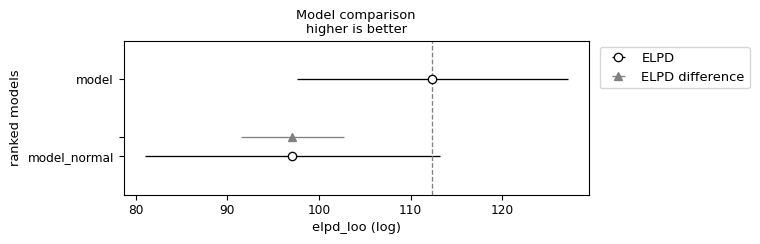

In [26]:
az.plot_compare(df_comp, insample_dev=False)
plt.show()

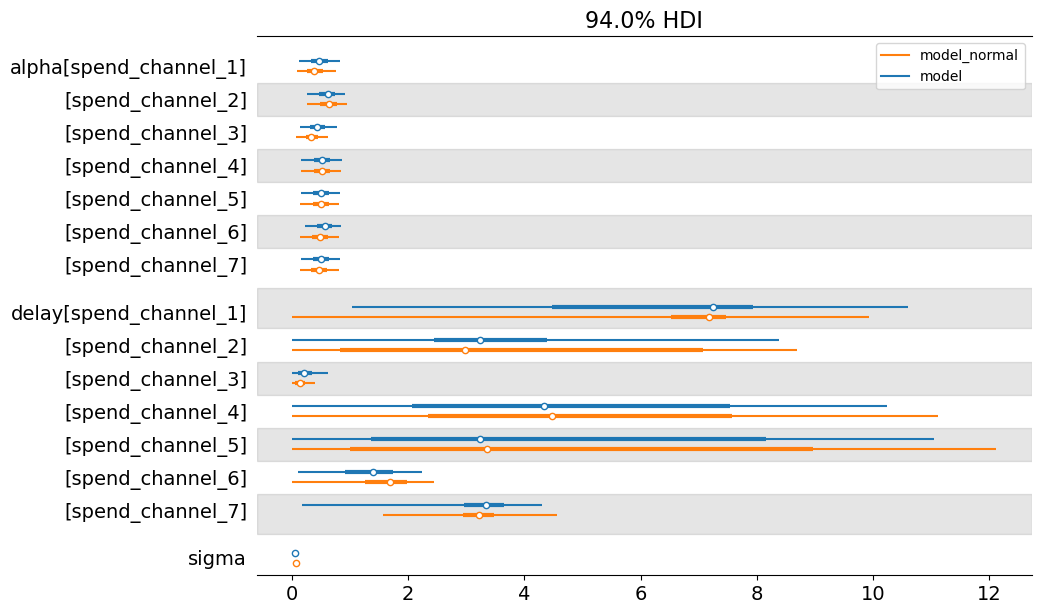

In [27]:
axes = az.plot_forest(
    data=[model_trace, model_trace_normal],
    model_names=["model", "model_normal"],
    var_names=['alpha','delay','sigma'],
    combined=True,
    figsize=(10, 7),
)
plt.show()

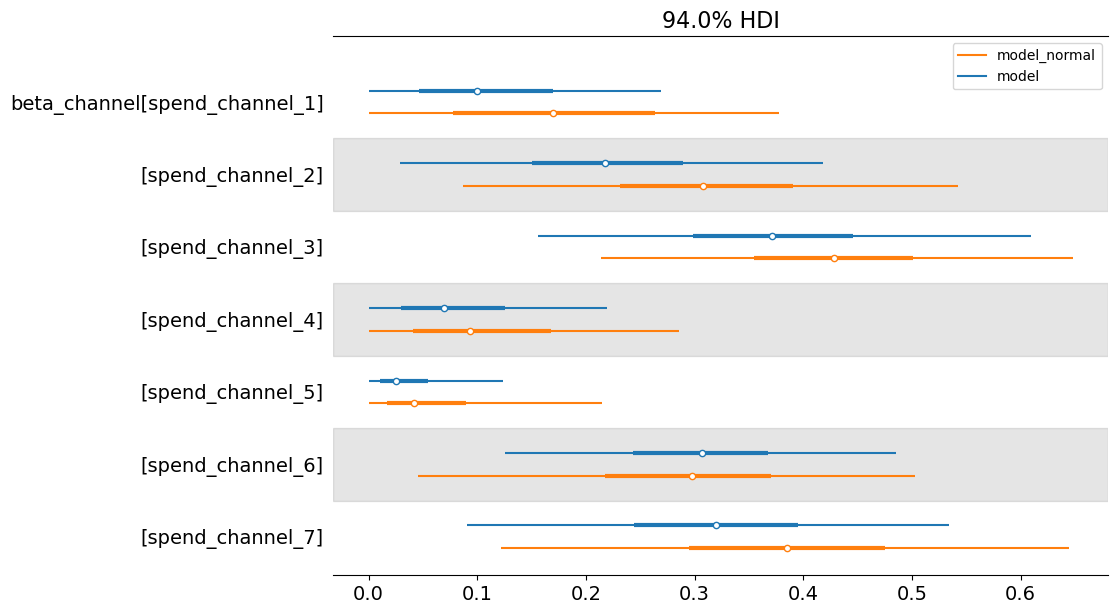

In [28]:
axes = az.plot_forest(
    data=[model_trace, model_trace_normal],
    model_names=["model", "model_normal"],
    var_names=['beta_channel'],
    combined=True,
    figsize=(10, 7),
)
plt.show()